# DSML Final Project
Emma Lenze & Kai Rothe

In [1]:
import torch
import torch.nn as nn
from torch.optim import RMSprop
from torch.nn.init import uniform_
from torch.distributions.uniform import Uniform
from random import randint
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os
import datetime

# https://github.com/rtqichen/torchdiffeq
from torchdiffeq import odeint_adjoint as odeint

## The model: a NeuralODE

In [2]:
class NeuralODE(nn.Module):
    """linear ReLU-FNN with one hidden layer of hidden dimension L and input and output dimension M; 
        and "method" of intergretion for generating trajectory"""
    
    def __init__(self, M, L, method = 'dopri5'):
        super(NeuralODE, self).__init__()
        
        self.method = method
        
        self.net = nn.Sequential( 
            nn.Linear(M, L),
            nn.ReLU(),
            nn.Linear(L, M)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x0):
        """generate derivatives from time series starting from x0, evaluated at time points t"""
        return self.net(x0)
    
    @torch.no_grad()
    def generate_trajectory(self, t, x0):
        """generate trajectory starting from y0, evaluated at time points t"""
        return odeint(self, x0, t, method = self.method)

In [3]:
def train(model, dataset, num_epochs, learning_rate=1e-3, test_freq=10): 
    """
    Simple training method. Train `model` for `num_epochs` where one epoch is defined
    by processing a single training batch.
    """
    
    optimizer = RMSprop(model.parameters(), lr=learning_rate) # TODO: maybe rather use torch.optim.RAdam(model.parameters(), lr=learning_rate)
    losses = []
    
    with trange(num_epochs, unit="batches") as pbar:
        pbar.set_description(f"Training Progress")
        
        for epoch in pbar:
            optimizer.zero_grad()
            X0, T_eval, X = dataset.sample_batch()
            X_pred = odeint(model, X0, T_eval)
            loss = torch.mean(torch.abs(X_pred - X)) # TODO maybe rather use: loss_fn = nn.MSELoss(); loss = loss_fn(pred_y, batch_y)
            loss.backward()
            optimizer.step()
            
            if epoch % test_freq == 0:
                pbar.set_postfix(loss=loss.item())
            losses.append(loss.item())
    
    return losses

## Training & Evaluation Utilities

In [4]:
def visualize_data(X_train, X_test, idx_end = 1000):
    fig = plt.figure(figsize=(12, 10))

    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot3D(X_train[:, 0], X_train[:, 1], X_train[:, 2])
    ax1.set_title('Training trajectory')

    ax2 = fig.add_subplot(222, projection='3d')
    ax2.plot3D(X_test[:, 0], X_test[:, 1], X_test[:, 2])
    ax2.set_title('Testing trajectory')

    ax3 = fig.add_subplot(223)
    ax3.plot(X_train[1:idx_end, 0])
    ax3.set_xlabel("time")
    ax3.set_ylabel("x")

    ax4 = fig.add_subplot(224)
    ax4.plot(X_test[1:idx_end, 0])
    ax4.set_xlabel("time")
    ax4.set_ylabel("x")

    plt.tight_layout()
    plt.show()

# import & visualize data
def import_data(data = "lorenz63", viz = True):
    X_train = np.load("./data/" + data + "_on0.05_train.npy").astype(np.float32)
    X_test = np.load("./data/" + data + "_test.npy").astype(np.float32)
    
    if viz == True:
        visualize_data(X_train, X_test, idx_end = 1000)
        
    return X_train, X_test

In [5]:
class TimeSeriesDataset():
    """
    The dataset. It stores the observed orbit `X_train` of shape `T x N`. 
    During training, this class provides batches of subsequences from the data of shape T x B x N.
    """
    def __init__(self, X_train, X_test, sequence_length=10, batch_size=20, time_step=1):
        assert X_train.shape[0] == X_test.shape[0]
        
        self.X = torch.tensor(X_train, dtype=torch.float32)
        self.test = torch.tensor(X_test, dtype=torch.float32)
        self.total_time_steps = self.X.shape[0]
        self.sequence_length = sequence_length
        self.batch_size = batch_size 
        self.time_step = time_step
        self.T_eval = torch.arange(0., time_step * sequence_length, step=time_step, dtype = torch.float32)
        
    def __len__(self):
        return self.total_time_steps - self.sequence_length

    def __getitem__(self, idx):
        X0 = self.X[idx, :]
        X = self.X[idx:(idx + self.sequence_length + 1), :]
        return X0, self.T_eval, X
    
    def sample_batch(self):
        """
        Sample a batch of sequences, returning 
            - initial conditions X0 (B x N)
            - times of evaluations T_eval (sequence_length)
            - batch of sequences X (sequence_length x B x N)
        """
        idxs = torch.from_numpy(np.random.choice(np.arange(len(self), dtype=np.int64), self.batch_size, replace=False))
        X0 = self.X[idxs]  # batch_size x N
        X = torch.stack([self.X[idxs + i] for i in range(self.sequence_length)], dim=0) # sequence_length x batch_size x N
        return X0, self.T_eval, X

In [7]:
def plot_losses(losses):
    # plot the loss
    plt.plot(losses)
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.title("Training loss")
    plt.show()

def visualize_trajectories(X_true, X_gen, idx_end = 1000):
    fig = plt.figure(figsize=(12, 10))

    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot3D(X_true[:, 0], X_true[:, 1], X_true[:, 2])
    ax1.set_title('Ground Truth')

    ax2 = fig.add_subplot(222, projection='3d')
    ax2.plot3D(X_gen[:, 0], X_gen[:, 1], X_gen[:, 2])
    ax2.set_title('Generated trajectory')

    ax3 = fig.add_subplot(223)
    ax3.plot(X_true[1:idx_end, 0])
    ax3.set_xlabel("time")
    ax3.set_ylabel("x")

    ax4 = fig.add_subplot(224)
    ax4.plot(X_gen[1:idx_end, 0])
    ax4.set_xlabel("time")
    ax4.set_ylabel("x")

    plt.tight_layout()
    plt.show()

In [52]:
# draw random initial condition, return generated trajectory and visualize result
@torch.no_grad()
def draw_and_visualize(model, dataset, x0 = None, viz = True, test_precision = 1.):
    if x0 == None:
        # draw random trajectory within phase space of training trajectory
        max_values = torch.max(dataset.test, dim = 0)[0]
        min_values = torch.min(dataset.test, dim = 0)[0]
        unif_distr = Uniform(min_values, max_values)
        x0 = unif_distr.rsample((1,))[0]
    
    t_gen = torch.arange(0., dataset.total_time_steps * dataset.time_step, test_precision * dataset.time_step, dtype = torch.float32)
    X_gen = model.generate_trajectory(t_gen, x0)
    
    if viz == True:
        visualize_trajectories(dataset.test, X_gen, idx_end = 1000)

    return X_gen

In [9]:
# include psd.py snippet
# compute power spectra distances and average across all dimensions
@torch.no_grad()
def power_spectrum_error(x_gen, x_true, smoothing_sigma=20):
    pse_errors_per_dim = power_spectrum_error_per_dim(x_gen, x_true, smoothing_sigma)
    return np.array(pse_errors_per_dim).mean(axis=0)

def compute_power_spectrum(x, smoothing_sigma=20):
    fft_real = np.fft.rfft(x)
    ps = np.abs(fft_real)**2
    ps_smoothed = gaussian_filter1d(ps, smoothing_sigma)
    return ps_smoothed

def get_average_spectrum(x, smoothing_sigma = 20):
    x_ = (x - x.mean()) / x.std()  # normalize individual trajectories
    spectrum = compute_power_spectrum(x_, smoothing_sigma)
    return spectrum / spectrum.sum()

def power_spectrum_error_per_dim(x_gen, x_true, smoothing_sigma=20): # Batch Size x Time x Dimension 
    assert x_true.shape[1] == x_gen.shape[1]
    assert x_true.shape[2] == x_gen.shape[2]
    dim_x = x_gen.shape[2]
    pse_per_dim = []
    for dim in range(dim_x):
        spectrum_true = get_average_spectrum(x_true[:, :, dim], smoothing_sigma)
        spectrum_gen = get_average_spectrum(x_gen[:, :, dim], smoothing_sigma)
        hd = hellinger_distance(spectrum_true, spectrum_gen)
        pse_per_dim.append(hd)
    return pse_per_dim

def hellinger_distance(p, q):
    return 1 / np.sqrt(2) * np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Training 

## 1) Lorenz63

In [107]:
# hyperparameters
integration_method = 'dopri5' # choices = ['dopri5', 'adams']
time_step = 1 # 0.01 originally but with 1 muuuch faster.. 
hidden_size = 50
batch_size = 20 
learning_rate = 1e-3

# most important
sequence_length = 30 # 75
num_epochs = 5000 # 2000

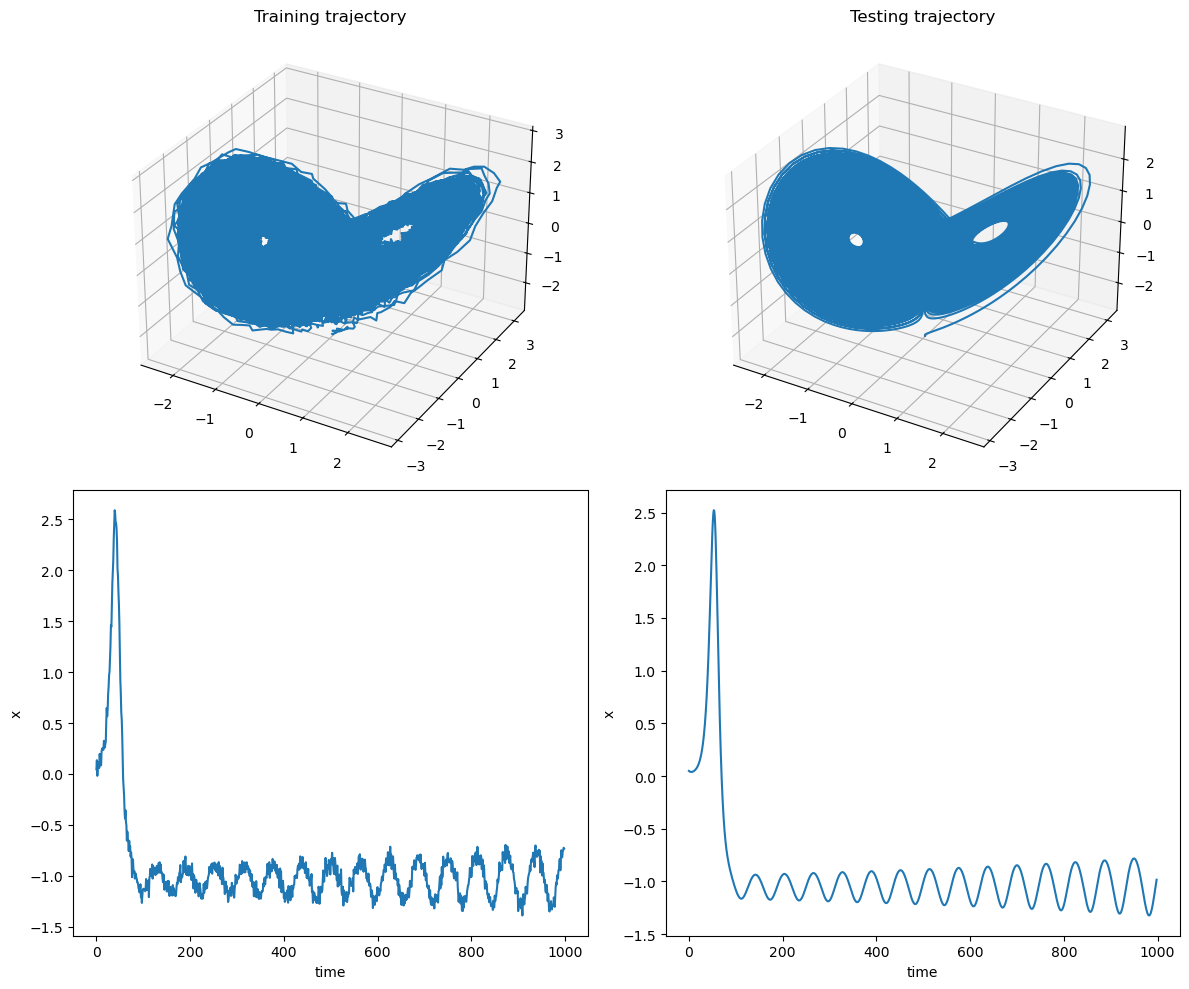

T = 100000
M = 3


In [40]:
# import data & create dataset
X_train, X_test = import_data(data = "lorenz63", viz = True)
latent_size = X_train.shape[1]
print("T =", X_train.shape[0])
print("M =", latent_size)
dataset_63 = TimeSeriesDataset(X_train, X_test, sequence_length=sequence_length, batch_size=batch_size, time_step=time_step)

In [109]:
model63 = NeuralODE(latent_size, hidden_size, method=integration_method)
current_time = datetime.datetime.now()
model_name = "NeuralODE_Lorenz63_" + str(current_time)

Training Progress: 100%|█| 5000/5000 [4:55:38<00:00,  3.55s/batches, loss=0.0798


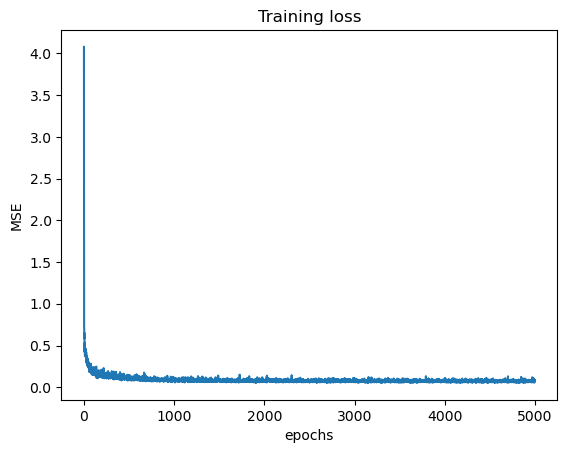

In [110]:
# actual training routine call
losses = train(model63, dataset_63, num_epochs)

# you can save the model here
torch.save(model63.state_dict(), "./models/" + model_name + ".pt")

# visualize losses
plot_losses(losses)

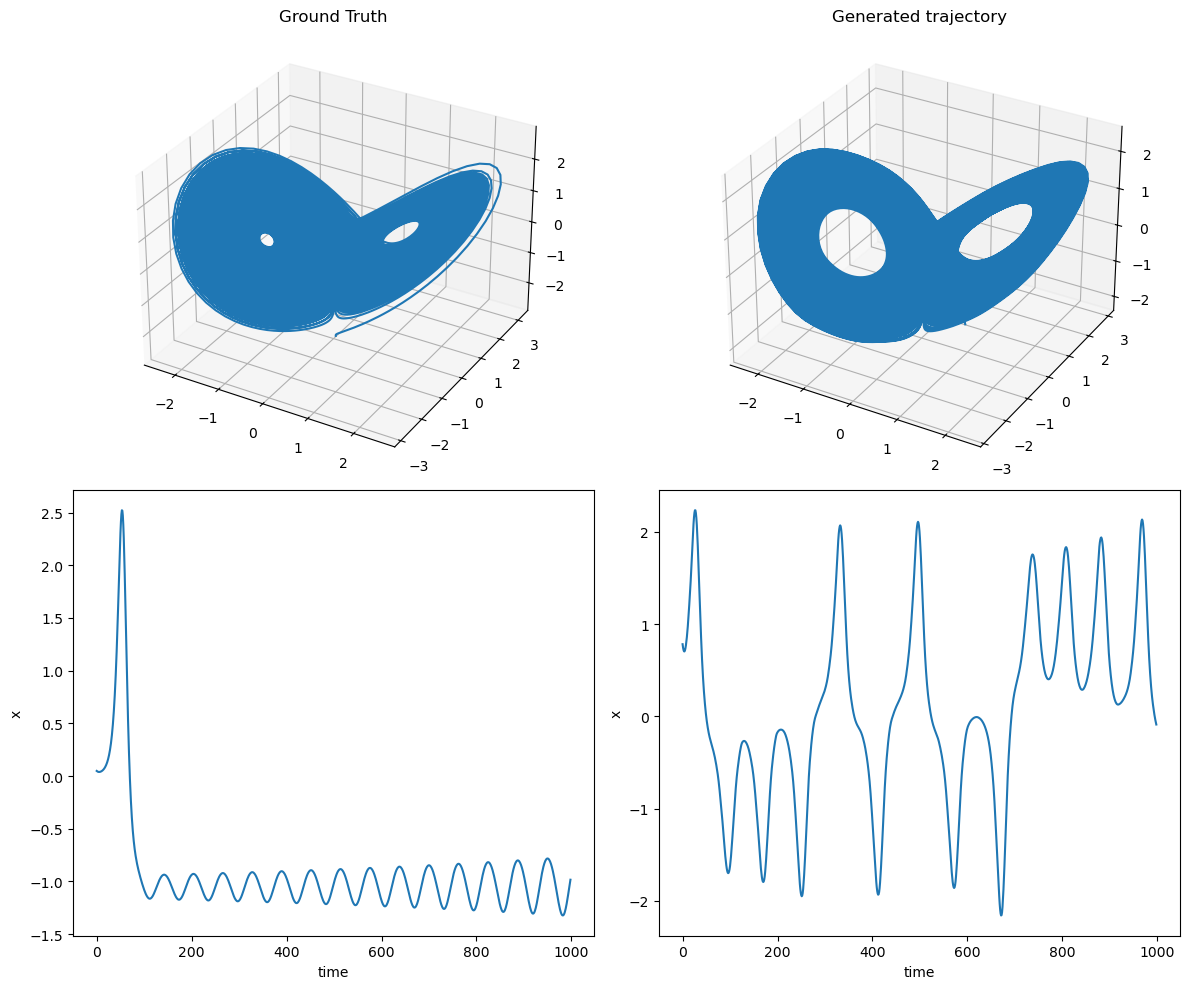

In [113]:
# evaluate model
x0 = None # dataset_63.test[0, :]
X_gen = draw_and_visualize(model63, dataset_63, x0 = x0, viz = True, test_precision = 1.)

In [114]:
# compute power spectrum
T = X_gen.shape[0]
dataset_63.test.reshape(1, T, latent_size)
power_spectrum_error(X_gen.reshape(1, T, latent_size), dataset_63.test.reshape(1, T, latent_size))

0.20716995346386033

## 2) Lorenz96

In [167]:
# hyperparameters
integration_method = 'dopri5' # choices = ['dopri5', 'adams']
time_step = 0.01
hidden_size = 333
batch_size = 20 
learning_rate = 5e-3

# most important
sequence_length = 75 # 10 # 30 # 75
num_epochs = 1000 # 500 # 1000 # 5000 # 2000

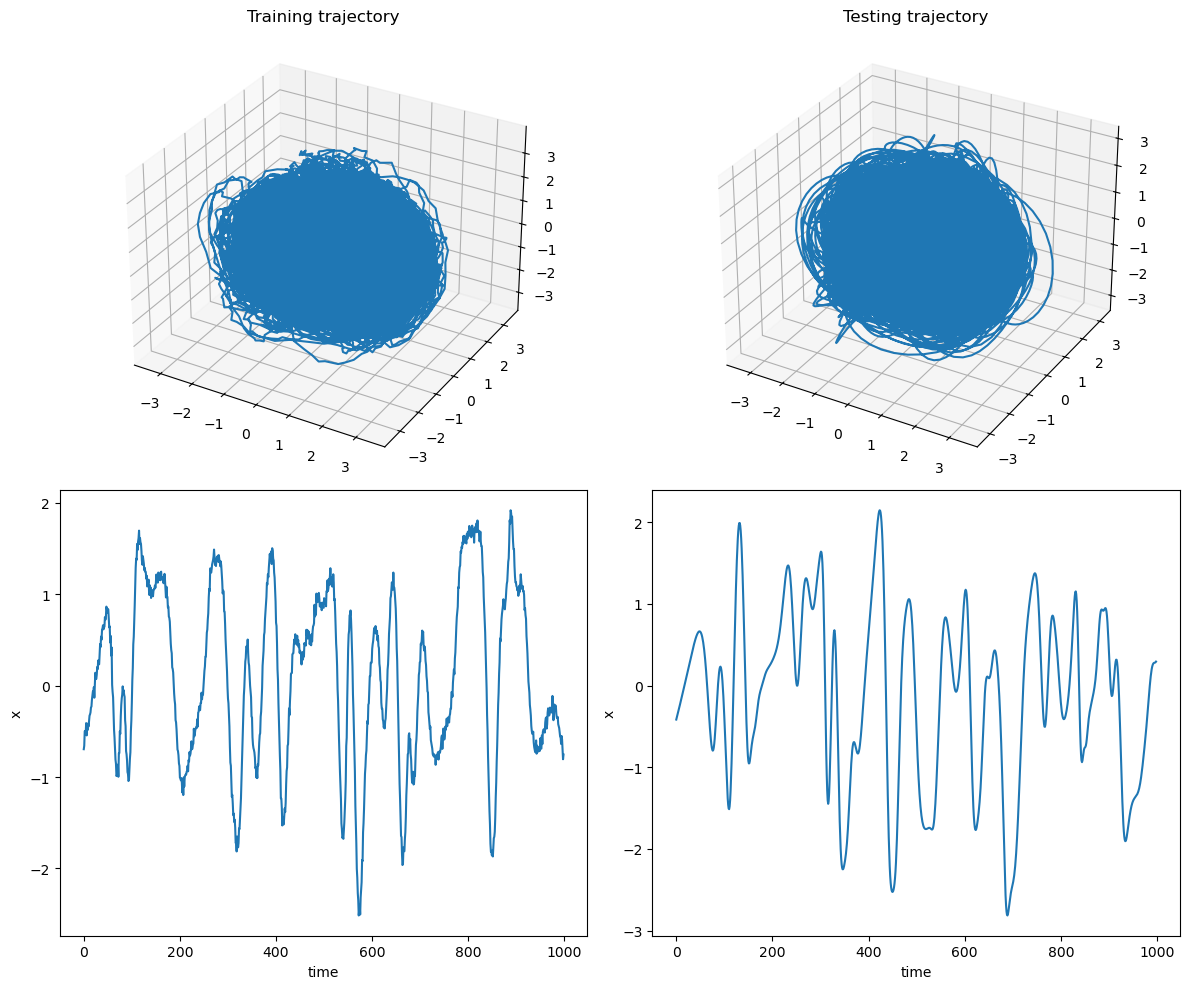

T = 100000
M = 20


In [168]:
# import data & create dataset
X_train, X_test = import_data(data = "lorenz96", viz = True)
latent_size = X_train.shape[1]
print("T =", X_train.shape[0])
print("M =", latent_size)
dataset_96 = TimeSeriesDataset(X_train, X_test, sequence_length=sequence_length, batch_size=batch_size, time_step=time_step)

In [169]:
model96 = NeuralODE(latent_size, hidden_size, method=integration_method)

In [ ]:
# """ train
current_time = datetime.datetime.now()
model_name = "NeuralODE_Lorenz96_" + str(current_time)

# actual training routine call
losses = train(model96, dataset_96, num_epochs)

# you can save the model here
# torch.save(model96.state_dict(), "./models/" + model_name + ".pt")

# visualize losses
plot_losses(losses)
# """

# or load:
# model_name = "..."
# model96.load_state_dict(torch.load(), "./models/" + model_name + ".pt")
# model96.eval()

Training Progress:  22%|▊   | 217/1000 [05:12<20:55,  1.60s/batches, loss=0.692]

In [ ]:
# evaluate model
X_gen = draw_and_visualize(model96, dataset_96, x0 = dataset_96.test[0, :], viz = True, test_precision = 1.)

In [ ]:
# compute power spectrum
T = X_gen.shape[0]
power_spectrum_error(X_gen.reshape(1, T, latent_size), dataset_96.test[:,:].reshape(1, T, latent_size))